In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

from scipy.optimize import newton

from utils import *

from ipywidgets import interact

### create inverse problem

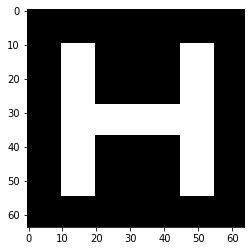

In [2]:
spread = [10,10]
size = 64
shape = (size, size)
pixels = shape[0] * shape[1]

x_true = build_x_true().reshape(-1,1)

plt.imshow(im(x_true, shape), cmap='Greys_r')

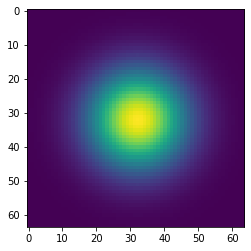

In [3]:
A = build_A(spread, shape)
plt.imshow(im(A[:, int(shape[0]**2/2 + shape[1]/2)], (size, size)))

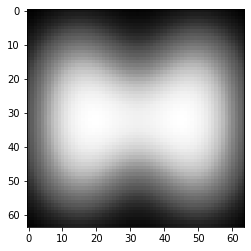

In [4]:
b_true = A @ x_true
plt.imshow(im(b_true, shape), cmap='Greys_r')

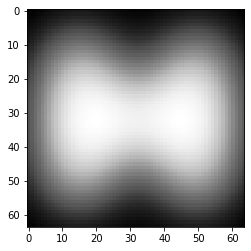

In [5]:
noise_level = 0.001
noise = np.random.randn(pixels)
e = noise_level * np.linalg.norm(b_true) / np.linalg.norm(noise) * noise
e = e.reshape(-1,1)
b = b_true + e

plt.imshow(im(b, shape), cmap='Greys_r')

### naive solution

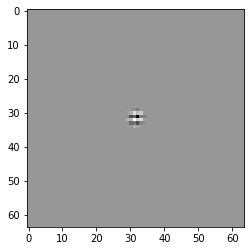

In [6]:
reconstruct = np.linalg.solve(A, b)

plt.imshow(im(reconstruct, shape), cmap='Greys_r')

### solve with truncated svd

In [7]:
U, S, VT = np.linalg.svd(A)
V = VT.T

In [8]:
def trunc_svd(x):
    r = x
    S_hat = S[0:r] #extract the first r singular values
    S_hat_mat = np.diag(S_hat) #form a diagonal matrix
    U_temp = U[:, 0:r]
    x_trunc = np.transpose(VT[0:r, :])@np.linalg.inv(S_hat_mat)@np.transpose(U_temp)@b

    plt.imshow(im(x_trunc, shape), cmap='Greys_r')

interact(trunc_svd, x=(1,200,1))

interactive(children=(IntSlider(value=100, description='x', max=200, min=1), Output()), _dom_classes=('widget-…

<function __main__.trunc_svd(x)>

### solve with tikhonov regularization

In [9]:
def tikhonov_solution(reg_param):

    x_tikhonov = tikhonov_solver(A, b, reg_param)

    plt.imshow(im(x_tikhonov, shape), cmap='Greys_r')

interact(tikhonov_solution, reg_param=(0,0.05,0.005))

interactive(children=(FloatSlider(value=0.025, description='reg_param', max=0.05, step=0.005), Output()), _dom…

<function __main__.tikhonov_solution(reg_param)>

### solve with arnoldi

In [10]:
def arnoldi_solution(n):

    x_arnoldi = arnoldi_solver(A, n, b)

    plt.imshow(im(x_arnoldi, shape), cmap='Greys_r')

interact(arnoldi_solution, n=(1,20,1))

interactive(children=(IntSlider(value=10, description='n', max=20, min=1), Output()), _dom_classes=('widget-in…

<function __main__.arnoldi_solution(n)>

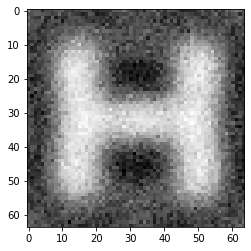

In [11]:
x_arnoldi = arnoldi_solver(A, 15, b)
fig = plt.figure()
plt.imshow(im(x_arnoldi, shape), cmap='Greys_r')

plt.savefig('../figures/arnoldi/arnoldi_15')

### solve with arnoldi + tikhonov

In [12]:
def arnoldi_tikhonov_solution(n, reg_param):

    x_arnoldi_tikhonov = arnoldi_tikhonov_solver(A, n, b, reg_param)

    plt.imshow(im(x_arnoldi_tikhonov, shape), cmap='Greys_r')

interact(arnoldi_tikhonov_solution, n=(1,20,1), reg_param=(0,0.05,0.005))

interactive(children=(IntSlider(value=10, description='n', max=20, min=1), FloatSlider(value=0.025, descriptio…

<function __main__.arnoldi_tikhonov_solution(n, reg_param)>

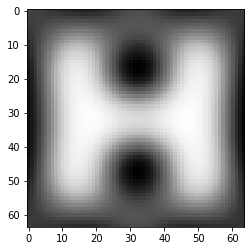

In [13]:
n = 15
lamb = 0.0001

x_arnoldi_tikhonov = arnoldi_tikhonov_solver(A, n, b, lamb)
fig = plt.figure()
plt.imshow(im(x_arnoldi_tikhonov, shape), cmap='Greys_r')

plt.savefig(f'../figures/arnoldi_tikhonov/arnoldi_{n}_lambda_{lamb}.png')

### relative reconstruction error as a function of iterations and regularization parameter

In [14]:
lambda_vals = np.linspace(0,0.001,100)

iteration_vals = np.array(range(1,21), dtype=np.int64)

Lambdas, Iterations = np.meshgrid(lambda_vals, iteration_vals)

grid = pd.DataFrame({'lambda':Lambdas.flatten(), 'arnoldi_iterations':Iterations.flatten()})

grid['RRE'] = grid.apply(lambda x: np.linalg.norm(arnoldi_tikhonov_solver(A, int(x['arnoldi_iterations']), b, x['lambda']) - x_true)/np.linalg.norm(x_true), axis=1)

z_data = grid['RRE'].to_numpy().reshape(20,100)

In [15]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(x=Lambdas, y=Iterations, z=z_data)])

fig.update_layout(title='RRE vs regularization parameter and number of Arnoldi iterations', autosize=False,
                  width=1000, height=1000, scene=dict(xaxis_title='lambda', yaxis_title='iterations'),
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

best parameters in grid

In [16]:
grid.iloc[grid['RRE'].argmin(), :]

lambda                 0.000000
arnoldi_iterations    14.000000
RRE                    0.458483
Name: 1300, dtype: float64

best lambda for every number of iterations

In [17]:
grid.loc[grid.groupby(by='arnoldi_iterations')['RRE'].idxmin()].to_csv('../data/best_lambda_for_iterations_gridsearch.csv')

### discrepancy principle for the unprojected problem

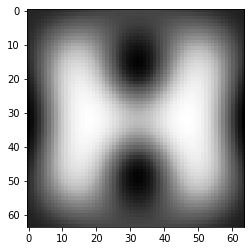

In [18]:
eta = 1.0001

delta = np.linalg.norm(e)

lambda_star_unprojected = discrepancy_principle(A, b, eta, delta)

x_star_unprojected = tikhonov_solver(A, b, lambda_star_unprojected)

plt.imshow(im(x_star_unprojected, shape), cmap='Greys_r')

In [19]:
RRE_x_star_unprojected = np.linalg.norm(x_star_unprojected - x_true)/np.linalg.norm(x_true)
print(RRE_x_star_unprojected)
print(lambda_star_unprojected)

0.5331686714690702
0.0005732553340101349


### discrepancy principle for the projected problem

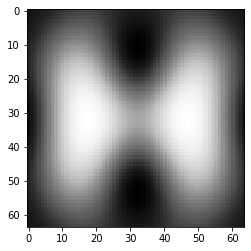

In [20]:
Q, H = arnoldi(A, 14, b) # 14 was the best choice in the grid search

b_hat = Q.T @ b

lambda_star_projected = discrepancy_principle(H, b_hat, eta, delta)

x_star_projected = arnoldi_tikhonov_solver(A, 14, b, lambda_star_projected)

plt.imshow(im(x_star_projected, shape), cmap='Greys_r')

In [21]:
RRE_x_star_projected = np.linalg.norm(x_star_projected - x_true)/np.linalg.norm(x_true)
print(RRE_x_star_projected)
print(lambda_star_projected)

0.5733572333552183
0.004751385965134261


In [22]:
iterations = list(range(1,21))
lambdas = []

for iter in iterations:
    Q, H = arnoldi(A, iter, b) # 14 was the best choice in the grid search

    b_hat = Q.T @ b

    lambda_star_projected = discrepancy_principle(H, b_hat, eta, delta)

    lambdas.append(lambda_star_projected)

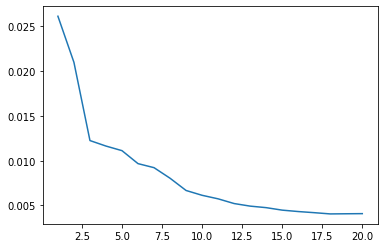

In [23]:
plt.plot(iterations, lambdas)

In [24]:
import plotly.express as px

fig = px.line(x=iterations, y=lambdas, labels={
                     "x": "Arnoldi iterations",
                     "y": "lambda"
                 })


fig.show()